## Tensores

In [ ]:
import torch
import numpy as np

In [ ]:
rand_tensor = torch.rand(2,3)
rand_tensor

tensor([[0.8402, 0.8031, 0.2252],
        [0.7101, 0.2750, 0.7136]])

In [ ]:
t = torch.zeros(1,2,3,4)
t.shape

torch.Size([1, 2, 3, 4])

In [ ]:
t_squeezed = torch.squeeze(t,0)
t_squeezed.shape

torch.Size([2, 3, 4])

In [ ]:
from torch.utils.data import DataLoader

t = torch.arange(6,dtype=torch.float32)
dataloader = DataLoader(t)

In [ ]:
for item in dataloader:
  print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [ ]:
dataloader = DataLoader(t, batch_size=2, drop_last=False)

In [ ]:
for i, batch in enumerate(dataloader, 1):
  print(f"{i}", batch)

1 tensor([0., 1.])
2 tensor([2., 3.])
3 tensor([4., 5.])


## NN usando pytorch

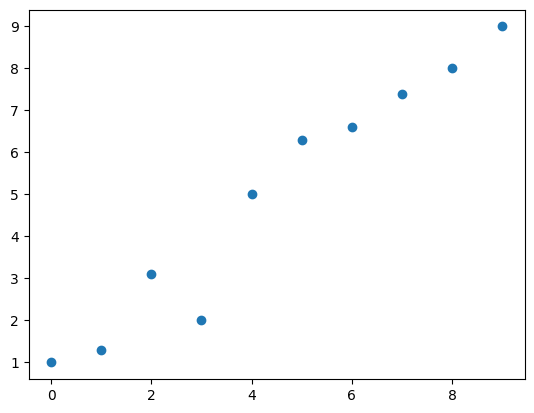

In [ ]:
import matplotlib.pyplot as plt

X_train = np.arange(10, dtype=np.float32).reshape((10,1))
y_train = np.array([1.0,1.3,3.1,2.0,5.0,6.3,
                    6.6,7.4,8.0,9.0], dtype='float32')

plt.plot(X_train, y_train, 'o')
plt.show()

In [ ]:
from torch.utils.data import TensorDataset

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(y_train)

train_ds = TensorDataset(X_train_norm, y_train)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

In [ ]:
weight = torch.randn(1, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

def model(xb):
  return xb * weight + bias

def loss_fn(input, target):
  return (input-target).pow(2).mean()

## Implementing a CNN

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

In [2]:
mnist_data, mnist_target = mnist['data'], mnist['target']

import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

mnist_data = StandardScaler().fit_transform(mnist_data)

mnist_data_train, mnist_data_test, mnist_target_train, mnist_target_test = train_test_split(
    mnist_data, mnist_target, test_size=0.2
    )

mnist_target_train = mnist_target_train.astype(np.int8)

mnist_target_train = torch.from_numpy(mnist_target_train.to_numpy())


In [3]:
mnist_data_train = torch.from_numpy(mnist_data_train).reshape(-1,1,28,28)
mnist_data_train.shape

torch.Size([56000, 1, 28, 28])

In [4]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(mnist_data_train, mnist_target_train)
dl_train = DataLoader(train_ds, batch_size=64)

In [26]:
for batch in dl_train:
  print(batch[0].shape)
  break

torch.Size([64, 784])


In [5]:
import torch.nn as nn

#First convolutional layer
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
#Relu and pooling
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
#Second convolutional layer
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)

#Relu and pooling

model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [6]:
x = torch.ones((4,1,28,28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [7]:
model.add_module('flatten',nn.Flatten())
model(x).shape

torch.Size([4, 3136])

In [8]:
model.add_module('fc1', nn.Linear(64*7*7, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
from sklearn.model_selection import cross_val_score

def train(model, num_epochs, train_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    #Begin in epoch cicle
    for epoch in range(num_epochs):
      #set the model in train mode (we need to do this because of the dropout)
      model.train()

      for x_batch, y_batch in train_dl:
        x_batch = x_batch.float()
        pred = model(x_batch)
        #Define loss function
        loss = loss = loss_fn(pred, y_batch.type(torch.LongTensor))
        #Retropropagation
        loss.backward()
        #Apply gradient to the weights
        optimizer.step()
        #Make gradients zero
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()*y_batch.size(0)
        #Validation mode
        #model.eval()
        #scores = cross_val_score(x_batch, y_batch, cv=10, scoring='log_loss')
        #loss_hist_valid[epoch] += scores.mean()*y_batch.size(0)

      #Normalice the loss record
      loss_hist_train[epoch] /= len(train_dl.dataset)


    return loss_hist_train, loss_hist_valid

In [15]:
hist_train, hist_valid = train(model, num_epochs=20, train_dl=dl_train)

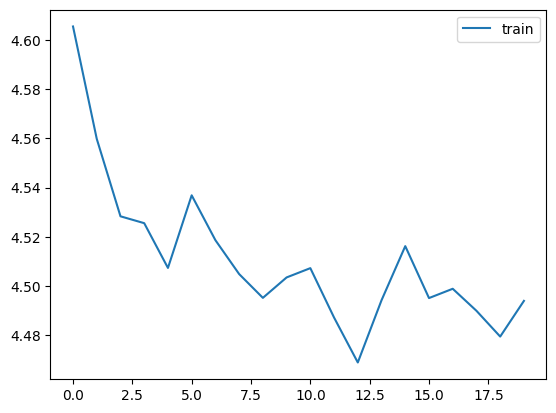

In [16]:
import matplotlib.pyplot as plt

plt.plot(hist_train, label='train')
#plt.plot(hist_valid, label='valid')
plt.legend()
plt.show()